# Import Modules and Load Primary Data Set

In [1]:
# import primary utility modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# import project specific utilities 
from utilities import *

In [2]:
# set the path to the (melissa's) filtered datasets
patient_cohort_data_dir = Path("/mnt/Swift/Data/DRTED/DRTEDv5/DS22v0_creatinine/icu")

# get a list of all hdf files in melissa's cohort filtered datasets directory
hdf_files = list(patient_cohort_data_dir.glob('*.hdf')) 

# make sure the text set is not being read/looked at
hdf_train_val_files = [file for file in hdf_files if 'test' not in str(file).lower()]

# read in an hdf file for preliminary purposes
raw_df = pd.read_hdf(list(hdf_train_val_files)[0])

In [ ]:
t = pd.read_hdf(hdf_train_val_files[0]).iloc[0:100, 70:100]
v = pd.read_hdf(hdf_train_val_files[1]).iloc[0:100, 70:100]
display(v)

v = v.ffill()

for col in v.columns:
    v[col] = v[col].fillna(t.mean()[col])
v

In [5]:
impute_df(dataframe = v, imputation_method = 'training set mean', impute_value = -999, training_set = t)

event_cd_display      Glasgow Coma Score  Hemofiltration Fluid Output  \
encounter  time_step                                                    
5170359954 0                    5.142857                          NaN   
           1                   14.000000                          NaN   
           2                   14.000000                          NaN   
           3                   14.000000                          NaN   
           4                   14.000000                          NaN   
...                                  ...                          ...   
           95                  14.000000                          NaN   
           96                  14.000000                          NaN   
           97                  14.000000                          NaN   
           98                  14.000000                          NaN   
           99                  14.000000                          NaN   

event_cd_display      Head Circumference  Heart Rate  Heart Sounds_murmur  \
encounter  time_step                                                        
5170359954 0                        30.5       204.0                  NaN   
           1                        30.5       168.0                  NaN   
           2                        30.5       168.0                  NaN   
           3                        30.5       152.0                  NaN   
           4                        30.5       152.0                  NaN   
...                                  ...         ...                  ...   
           95                       30.5       166.0                  NaN   
           96                       30.5       127.0                  NaN   
           97                       30.5       127.0                  NaN   
           98                       30.5       117.0                  NaN   
           99                       30.5       117.0                  NaN   

event_cd_display      Heart Sounds_gallop  Heart Sounds_click  \
encounter  time_step                                            
5170359954 0                          NaN                 NaN   
           1                          NaN                 NaN   
           2                          NaN                 NaN   
           3                          NaN                 NaN   
           4                          NaN                 NaN   
...                                   ...                 ...   
           95                         NaN                 NaN   
           96                         NaN                 NaN   
           97                         NaN                 NaN   
           98                         NaN                 NaN   
           99                         NaN                 NaN   

event_cd_display      Heart Sounds_frictionrub  Heart Sounds_normal  Height  \
encounter  time_step                                                          
5170359954 0                               NaN                  1.0    43.0   
           1                               NaN                  1.0    43.0   
           2                               NaN                  1.0    43.0   
           3                               NaN                  1.0    43.0   
           4                               NaN                  1.0    43.0   
...                                        ...                  ...     ...   
           95                              NaN                  1.0    43.0   
           96                              NaN                  1.0    43.0   
           97                              NaN                  1.0    43.0   
           98                              NaN                  1.0    43.0   
           99                              NaN                  1.0    43.0   

event_cd_display      ...  Oxygenation Index  PaO2 to FiO2  \
encounter  time_step  ...                                    
5170359954 0          ...                NaN      

# Get Variables and Medications of Interest

In [13]:
# load the labeled variable data set
# what is this (ADD)
labeled_vars_path = "/mnt/Swell/Users/brubel/projects/creatinine/dataset_generation/vars_info_picu_crcl.xlsx"
labeled_variables_df = pd.read_excel(labeled_vars_path, engine='openpyxl')

# Get medication and vital columns that neely marked as ** DO NOT ** discard
# NOTE: some labs are incorrectly labeled as vitals. We need to get rid of them later.
med_variables_neely = list(labeled_variables_df[(labeled_variables_df['categ'] == 'Drugs') & (labeled_variables_df['Discard'] == 0.0)]['Unnamed: 0'])
vital_variables_neely_unchecked = list(labeled_variables_df[(labeled_variables_df['categ'] ==  'Vitals') & (labeled_variables_df['Discard'] == 0.0)]['Unnamed: 0'])
print('-------------')
print(f'Neely Labeled {len(med_variables_neely)} Meds as Do Not Discard and {len(vital_variables_neely_unchecked)} Vitals as Do Not Discard.')

# display information about medication protocols among medication variables
inter_meds = len([ i for i in med_variables_neely if '_inter' in i.lower()])
cont_meds = len([ i for i in med_variables_neely if '_cont' in i.lower()])
print('-------------')
print(f'Neely Labeled Inter {inter_meds} Meds and {cont_meds} Cont Meds for potential use.')

# display information about lab variables
lab_variables_neely = list(labeled_variables_df[(labeled_variables_df['categ'] ==  'Labs') & (labeled_variables_df['Discard'] == 0.0)]['Unnamed: 0'])
print('-------------')
print(f'Neely Labeled {len(lab_variables_neely)} Labs for potential use.')
print('-------------')

-------------
Neely Labeled 129 Meds as Do Not Discard and 41 Vitals as Do Not Discard.
-------------
Neely Labeled Inter 114 Meds and 15 Cont Meds for potential use.
-------------
Neely Labeled 106 Labs for potential use.
-------------


In [14]:
# remove incorrectly labeled labs from vitals variable list and move them to labs variable list 
print('-------------')
move_vitals_to_labs_vars = ['Plasma Hemoglobin', 'Vancomycin Random Level', 'Vancomycin Peak Level', 'Vancomycin Trough Level']
vital_variables_neely = [vit for vit in vital_variables_neely_unchecked if vit not in move_vitals_to_labs_vars]
print(f'New Vitals List Now Has {len(vital_variables_neely)} Variables Without : {move_vitals_to_labs_vars}')
print(f'Original Variable List had {len(vital_variables_neely_unchecked)} Variables')
print('-------------')

# add new lab variables to lab variables list and remove Creatinine from lab aggregation
# our input dataframe is filtered on rows where there are Creatinine values recorded, so we don't have to aggregate on it.
labs_appended = list(set(lab_variables_neely + move_vitals_to_labs_vars))
labs_appended.remove('Creatinine')

# add inotrope score to labs list
# this is just because we want inotropes to be aggregated
# in the same way as we aggregate labs
intrope_col = ['inotrope_score']
labs_appended = list(set(labs_appended + intrope_col))
print(f'New Labs List Now Has {len(labs_appended)} Variables With : {move_vitals_to_labs_vars + intrope_col}')
print(f'Original Variable List had {len(lab_variables_neely)} Variables')
print('-------------')

# move ecmo to medication list so it follows same aggregation protocol
ecmo_cols = ['ECMO Type', 'ECMO Hours']
med_variables_neely_w_ecmo = list(set(med_variables_neely + ecmo_cols))
print(f'New Medications List Now Has {len(med_variables_neely_w_ecmo)} Variables With : {ecmo_cols}')
print(f'Original Variable List had {len(med_variables_neely)} Variables')
print('-------------')

# finalize what variables are going to be used in preproccessing and model development ( *** neely input needed TBD ***)
#
#
#
#
#
#
#
#
#

-------------
New Vitals List Now Has 37 Variables Without : ['Plasma Hemoglobin', 'Vancomycin Random Level', 'Vancomycin Peak Level', 'Vancomycin Trough Level']
Original Variable List had 41 Variables
-------------
New Labs List Now Has 110 Variables With : ['Plasma Hemoglobin', 'Vancomycin Random Level', 'Vancomycin Peak Level', 'Vancomycin Trough Level', 'inotrope_score']
Original Variable List had 106 Variables
-------------
New Medications List Now Has 131 Variables With : ['ECMO Type', 'ECMO Hours']
Original Variable List had 129 Variables
-------------


# Construct Aggregate Dataframes on (Melissa's) Filtered Datasets

### Construct Primary Aggregate Datasets

In [ ]:
# Load and Apply Aggregate Function to All Cohort Files

# create a new directory for saving aggregated results
aggregate_output_directory = Path("/mnt/Swift/Data/DRTED/DRTEDv5/DS22v0_creatinine/creatinine_aggs")
aggregate_output_directory.mkdir(parents = True, exist_ok = True)

# loop over hdf files in cohort dataset
for file in hdf_train_val_files:

    # Create empty dataframe to append aggregate dataframes 
    all_patient_agg_df = pd.DataFrame()
    
    # load cohort data
    raw_df = pd.read_hdf(file)

    # create non-empty creatinine data and gather eids
    non_empty_creatinine_df, cohort_eids = creat_eids_and_df(raw_df)

    # apply aggregate lookback function to each eid and append it to the main aggregation dataframe
    for crt_eid_i in tqdm(range(len(cohort_eids))):
        
        # apply the primary aggregation function
        agg_df = cr_lookback_aggregate_df(filtered_cohort_all_data = raw_df, 
                                            creatinine_measurement_rows_df = non_empty_creatinine_df, 
                                            eid = cohort_eids[crt_eid_i],
                                            vital_vars_list = vital_variables_neely, 
                                            med_vars_list = med_variables_neely_w_ecmo,
                                            lab_vars_list = labs_appended,
                                            lookback_window = 24.0)

        # add the aggregated eid dataframe to the main data frame
        all_patient_agg_df = pd.concat([all_patient_agg_df, agg_df])
        
    # save the results into a seperate directory
    output_file_path = aggregate_output_directory / (file.with_suffix('').name + '.hdf')
    print('Exporting Aggregate DF to: ', output_file_path)
#     all_patient_agg_df.to_hdf(output_file_path, key = 'agg_df')


### Add Additional Feature Columns to New, Aggregated Datasets 

In [ ]:
# create a new directory for aggregated files with additional features 
aggregates_w_features_output_dir = Path("/mnt/Swift/Data/DRTED/DRTEDv5/DS22v0_creatinine/creatinine_aggs_w_features")
aggregates_w_features_output_dir.mkdir(parents = True, exist_ok = True)

# Load the newly generated aggregated dataframes and create a list for iteration
aggregate_output_directory = Path("/mnt/Swift/Data/DRTED/DRTEDv5/DS22v0_creatinine/creatinine_aggs")
new_aggregated_hdf_files = list(aggregate_output_directory.glob('*.hdf'))

# iterate through every file, add year and pid for kfold splitting, and check the shape of the new dataframe
for i in range(len(new_aggregated_hdf_files)):

    print('------------------------------------------')
    # load aggregated file to which additional columns are going to be appended to 
    agg_file = new_aggregated_hdf_files[i]
    agg_df = pd.read_hdf(agg_file)
    print(f'Adding Raw Data Features to {agg_file} with shape {agg_df.shape}...')

    # merge year and pid to created aggregate data set 
    print(f'Getting Features From {hdf_train_val_files[i]}...')
    
    # get rows where creatinine is non empty from original data
    orig_cohort_df = pd.read_hdf(hdf_train_val_files[i])
    non_empty_creatinine_df, _ = creat_eids_and_df(orig_cohort_df)
    
    # 
    agg_df_w_feats = add_feats_to_df(aggregated_df = agg_df, 
                                     non_empty_filtered_df = non_empty_creatinine_df, 
                                     orig_feats_to_add_list = ['year','pid'])

    # save new augmented file to seperate directory
    output_file_path = aggregates_w_features_output_dir / (agg_file.with_suffix('').name + '_w_feats.hdf')
    # agg_df_w_feats.to_hdf(output_file_path, key = 'agg_df_w_feats')

    # display example of resulting output
    print(f'Shape of Aggregated Dataframe Now : {agg_df_w_feats.shape}')

In [ ]:
# rename Creatinine Truth Column in aggregated files
# create list of aggregated files with new features
aggregates_w_features_output_dir = Path("/mnt/Swift/Data/DRTED/DRTEDv5/DS22v0_creatinine/creatinine_aggs_w_features")
aggs_w_feats_hdf_files = list(aggregates_w_features_output_dir.glob('*.hdf'))

# iterate through all files
for agg_feat_file in aggs_w_feats_hdf_files:
    
    # load aggregated dataframe
    df = pd.read_hdf(agg_feat_file)
    
    # rename the Creatinine Truth column
    df = df.rename(columns = {'Creatinine_Truth':'Creatinine_48_hours_later'})
    
    # override the original file with the new creatinine truth column name
#     df.to_hdf(agg_feat_file, key = 'agg_df_w_feats')


### Fill Empty Values to Make Aggregate Datasets Usable for Model Development

In [ ]:
# calculate average summary statistics across all patients
train_picu_df_for_imputation = [f for f in hdf_train_val_files if ('train' in str(f).lower()) and ('picu' in str(f).lower())][0]
train_cticu_df_for_imputation = [f for f in hdf_train_val_files if ('train' in str(f).lower()) and ('cticu' in str(f).lower())][0]

# read in training sets from which to gather population means and other summary statistics
picu_train_df = pd.read_hdf(train_picu_df_for_imputation).iloc[:1000]
# cticu_train_df = pd.read_hdf(train_picu_df_for_imputation)

# calculate value tables for filling empty values based on specified training set
average_summary_matrix(picu_train_df, 'picu')

In [ ]:
# initialize the columns that are going to be filled
col_types_to_fill = ['Average', 'Median', 'Std', 'Max', 'Min', 'Count','_last_value' ]
df = pd.read_hdf(aggs_w_feats_hdf_files[0])

# iterate through every column in aggregate df that may contain NaN values
fill_na_cols = [c for c in df.columns if c.split('_')[-1] in col_types_to_fill or ('_last_value' in c)]

# apply the function to each agg dataframe and fill all empty columns with specified averaged values
for agg_path in aggs_w_feats_hdf_files:
    
    # read in the file being filled in with empty values and prompt user
    print(agg_path)
    df_w_nans = pd.read_hdf(agg_path)
    
    # determine what summary values file to use based on ICU type
    if 'cticu' in str(agg_path):
        print('Filling with Values from CTICU Training Set')
        sum_mat_icu_type = pd.read_csv('average_summary_stats_picu.csv')
        sum_mat_icu_type = sum_mat_icu_type.set_index(sum_mat_icu_type['event_cd_display'])   
    else:  
        print('Filling with Values from PICU Training Set')
        sum_mat_icu_type = pd.read_csv('average_summary_stats_cticu.csv')
        sum_mat_icu_type = sum_mat_icu_type.set_index(sum_mat_icu_type['event_cd_display'])

    # apply the function to every specified column in eveery dataset containing empty values
    df[fill_na_cols] = df[fill_na_cols].apply(lambda x: fill_all_na(x, df_w_nans, sum_mat_icu_type), axis = 0)
    
    # save the file that will now have no NANS 
    df.to_hdf(str(agg_path)[:-4] + '_imputed.hdf', key = 'imputed')

# Iterate through Model Training Outputs from DrSklearn

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


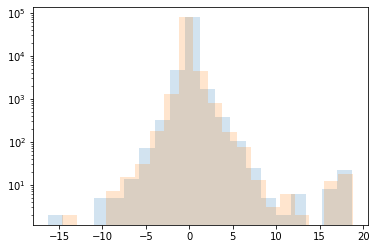

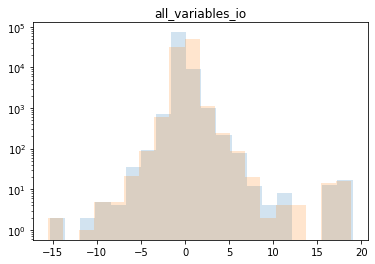

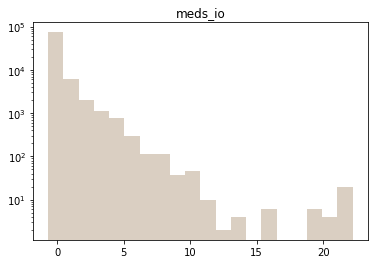

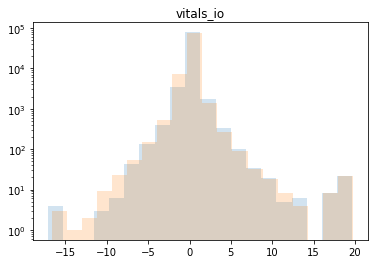

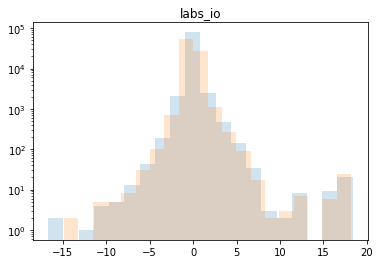

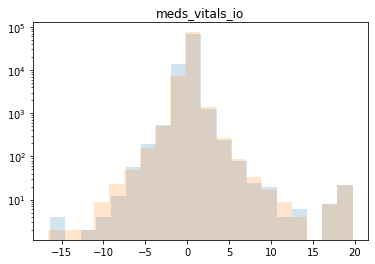

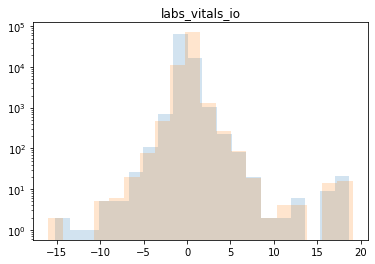

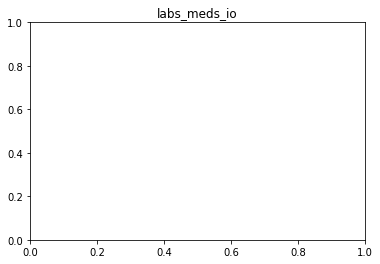

In [9]:
#
testing_sk_preds_path = "/mnt/Swell/Users/brubel/projects/creatinine/dataset_training/drsklearn/training_outputs/testtest/03-03-2023-13:55:19/preds.hdf"
preds = pd.read_hdf(testing_sk_preds_path)

#
for io in preds['io'].unique():
    
    #
    io_df = preds[(preds['io'] == io) & (preds['min_samples_split'] == 3)]
    io_df_2 = preds[(preds['io'] == io) & (preds['min_samples_split'] == 2)]
    
    #
    io_df['error'] = io_df['Creatinine_48_hours_later_truth'] - io_df['Creatinine_48_hours_later_pred']
    io_df_2['error'] = io_df_2['Creatinine_48_hours_later_truth'] - io_df_2['Creatinine_48_hours_later_pred']
    #
    
    plt.hist(io_df['error'], bins = 20, log = True, alpha = 0.2)
    plt.hist(io_df_2['error'], bins = 20, log = True, alpha = 0.2)
    plt.show()
    plt.title(io)

In [ ]:
s = pd.read_hdf(str(agg_path)[:-4] + '_no_NA.hdf')
plt.hist(s['Creatinine'], range = (0,30), log = True)
plt.hist(s['Creatinine_48_hours_later'],range = (0,30), log = True)
plt.legend(['Cr','Cr+48'])

In [ ]:
s = "/mnt/Swift/Data/DRTED/DRTEDv5/DS22v0_creatinine/creatinine_aggs_w_features/picu_trainPatients_w_feats_no_NA.hdf"
pd.read_hdf(s)

# Tune Paramters and Asses Performance

In [8]:
preds

Creatinine_48_hours_later_pred  \
EID        Timestep                                   
5124361156 63                              0.365498   
5181509069 39                              0.268898   
           39                              0.711973   
           39                              0.711973   
           39                              0.711973   
...                                             ...   
558478272  179                             0.317444   
           179                             0.317444   
           179                             0.435718   
           179                             0.441904   
5210712289 51                              0.428293   

                     Creatinine_48_hours_later_truth  fold                io  \
EID        Timestep                                                            
5124361156 63                               0.337034     0  all_variables_io   
5181509069 39                               0.273592     0           meds_io   
           39                               0.273592     0         vitals_io   
           39                               0.273592     0         vitals_io   
           39                               0.273592     0         vitals_io   
...                                              ...   ...               ...   
558478272  179                              0.302004     2           labs_io   
           179                              0.302004     2           labs_io   
           179                              0.302004     2  all_variables_io   
           179                              0.302004     2  all_variables_io   
5210712289 51                               0.358825     2  all_variables_io   

                     min_samples_split                            model_name  \
EID        Timestep                                                            
5124361156 63                        2  sklearn.ensemble.ExtraTreesRegressor   
5181509069 39                        3  sklearn.ensemble.ExtraTreesRegressor   
           39                        2  sklearn.ensemble.ExtraTreesRegressor   
           39                        2  sklearn.ensemble.ExtraTreesRegressor   
           39                        3  sklearn.ensemble.ExtraTreesRegressor   
...                                ...                                   ...   
558478272  179                       3  sklearn.ensemble.ExtraTreesRegressor   
           179                       3  sklearn.ensemble.ExtraTreesRegressor   
           179                       2  sklearn.ensemble.ExtraTreesRegressor   
           179                       3  sklearn.ensemble.ExtraTreesRegressor   
5210712289 51                        2  sklearn.ensemble.ExtraTreesRegressor   

                     n_estimators  random_state  Creatinine  
EID        Timestep                                          
5124361156 63                 100           8.0        0.36  
5181509069 39                 100           NaN        0.30  
           39                  50           8.0        0.30  
           39                 100           8.0        0.30  
           39                  50           8.0        0.30  
...                           ...           ...         ...  
558478272  179                 50           8.0        0.31  
           179                100           8.0        0.31  
           179                 50           8.0        0.31  
           179                 50           8.0        0.31  
5210712289 51                 100           8.0        0.36  

[1188068 rows x 9 columns]

# TODO's:
- 1) Implement " if first creatinine measurement, go to the beginning of the dataset" for summary stats
- 2) TBD : How to preproccess certain variables
- 3) come up with more features to "engineer" as columns in aggregated dataframe
- 4) Examine distributions of variables
- 5) search up more regression types
- 6) read random forest paper to understand what the hell is going on here 
- 7) come up with more parameters to tune model with
- 8) fix issue with the last io --> its blank
- 9) code review and or personally review code about filling in empty values + constructing datasets for modeling purposes
- 10) start looking for subsets of features rather than massive clusters of them
